# Example 10: Simple NPTF

Aim here is to perform very simple NPTF analyses to confirm we have the exposure correction setup correctly.

In [1]:
# Import relevant modules

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import healpy as hp
import corner
import matplotlib.pyplot as plt
from matplotlib import rcParams

from NPTFit import nptfit # module for performing scan
from NPTFit import dnds_analysis # module for analysing the output

## Isotropic Exposure with no Poisson fluctuations in counts

Aim is to see how well we can recover a Delta Function.

In [ ]:
# Setup data and exposure
nside = 16
nps = 100
npix = hp.nside2npix(nside)
data = np.zeros(npix)
for ips in range(nps):
    loc = np.random.randint(npix)
    data[loc] += 10
exposure = np.ones(npix)
#hp.mollview(data,title='Fake Data')
#hp.mollview(exposure,title='Exposure Map')
totaldata = np.sum(data)

# Setup and perform the scan
n = nptfit.NPTF(tag='Example10')
n.load_data(data, exposure)
nptf_iso = np.ones(npix)/exposure*np.mean(exposure)
n.add_template(nptf_iso, 'iso')
n.add_non_poiss_model('iso',
                      ['$A^\mathrm{ps}_\mathrm{iso}$','$n_1$','$n_2$','$S_b$'],
                      [[-3,0],[2.05,30],[-30,1.95],[0.01,20]],
                      [True,False,False,False])
n.configure_for_scan(nexp=1)
n.perform_scan(nlive=500)

# Load and analyze the output
n.load_scan()
an=dnds_analysis.Analysis(n)
an.make_triangle()
plt.show()
plt.close()

an.plot_source_count_median('iso',smin=0.01,smax=1000000,nsteps=10000,color='tomato',spow=0)
an.plot_source_count_band('iso',smin=0.01,smax=1000000,nsteps=10000,qs=[0.16,0.5,0.84],color='tomato',alpha=0.3,spow=0)
plt.yscale('log')
plt.xscale('log')
plt.xlim([1,100])
plt.ylim([1e-5,1e-2])
plt.ylabel('$dN/dF$', fontsize=18)
plt.xlabel('$F$', fontsize=18)
plt.show()
plt.close()

an.plot_intensity_fraction_non_poiss('iso', bins=800, color='tomato', label='Iso PS')
plt.close()
print "Flux fraction [16,50,84] percentiles:",an.qs_comp

# Manual calculation of the FF
Aiso_non_poiss_post, n_non_poiss_post, Sb_non_poiss_post = an.return_non_poiss_parameter_posteriors('iso')
A = np.percentile(Aiso_non_poiss_post,50)
n1 = np.percentile(n_non_poiss_post[0],50)
n2 = np.percentile(n_non_poiss_post[1],50)
Sb = np.percentile(Sb_non_poiss_post[0],50)

print "Median of each param FF:",A*np.sum(nptf_iso)*Sb**2*(1/(n1-2)+1/(2-n2))/totaldata*100
print "Median of FFs over params:",np.percentile(np.array(Aiso_non_poiss_post)*np.sum(nptf_iso)*np.array(Sb_non_poiss_post[0])**2*(1/(np.array(n_non_poiss_post[0])-2)+1/(2-np.array(n_non_poiss_post[1]))),50)/totaldata*100

## Isotropic Exposure with Poisson fluctuations in counts

In [ ]:
# Setup data and exposure
nside = 16
nps = 100
npix = hp.nside2npix(nside)
data = np.zeros(npix)
for ips in range(nps):
    loc = np.random.randint(npix)
    data[loc] += np.random.poisson(10)
exposure = np.ones(npix)
#hp.mollview(data,title='Fake Data')
#hp.mollview(exposure,title='Exposure Map')

# Setup and perform the scan
n = nptfit.NPTF(tag='Example10')
n.load_data(data, exposure)
nptf_iso = np.ones(npix)/exposure*np.mean(exposure)
n.add_template(nptf_iso, 'iso')
n.add_non_poiss_model('iso',
                      ['$A^\mathrm{ps}_\mathrm{iso}$','$n_1$','$n_2$','$S_b$'],
                      [[-3,0],[2.05,30],[-30,1.95],[0.01,20]],
                      [True,False,False,False])
n.configure_for_scan(nexp=1)
n.perform_scan(nlive=500)

# Load and analyze the output
n.load_scan()
an=dnds_analysis.Analysis(n)
an.make_triangle()
plt.show()
plt.close()

an.plot_source_count_median('iso',smin=0.01,smax=1000000,nsteps=10000,color='tomato',spow=0)
an.plot_source_count_band('iso',smin=0.01,smax=1000000,nsteps=10000,qs=[0.16,0.5,0.84],color='tomato',alpha=0.3,spow=0)
plt.yscale('log')
plt.xscale('log')
plt.xlim([1,100])
plt.ylim([1e-5,1e-2])
plt.ylabel('$dN/dF$', fontsize=18)
plt.xlabel('$F$', fontsize=18)
plt.show()
plt.close()

an.plot_intensity_fraction_non_poiss('iso', bins=800, color='tomato', label='Iso PS')
plt.close()
print "Flux fraction [16,50,84] percentiles:",an.qs_comp

# Manual calculation of the FF
Aiso_non_poiss_post, n_non_poiss_post, Sb_non_poiss_post = an.return_non_poiss_parameter_posteriors('iso')
A = np.percentile(Aiso_non_poiss_post,50)
n1 = np.percentile(n_non_poiss_post[0],50)
n2 = np.percentile(n_non_poiss_post[1],50)
Sb = np.percentile(Sb_non_poiss_post[0],50)

print "Median of each param FF:",A*np.sum(nptf_iso)*Sb**2*(1/(n1-2)+1/(2-n2))/totaldata*100
print "Median of FFs over params:",np.percentile(np.array(Aiso_non_poiss_post)*np.sum(nptf_iso)*np.array(Sb_non_poiss_post[0])**2*(1/(np.array(n_non_poiss_post[0])-2)+1/(2-np.array(n_non_poiss_post[1]))),50)/totaldata*100

## Simple Exposure Variation with no Poisson fluctuations in counts, using 1/exposure, exposure and isotropic as templates

[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  7  3  3  3  3  3  3  3  3  3  3  3  3  3
  3 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17]


/zfs/nrodd/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


No mask set; defaulting to a blank mask
d1: [ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  7  3  3  3  3  3  3  3  3  3  3  3  3  3
  3 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17]
d1t: True
d2: [ 3  3  3  3  7  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17]
d2t: True
The number of parameters to be fit is 4


ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

  analysing data from /zfs/nrodd/NPTFitCGamma/NPTFit/examples/chains/Example10/.txt


ValueError: invalid literal for float(): -0.139052003804992441-308

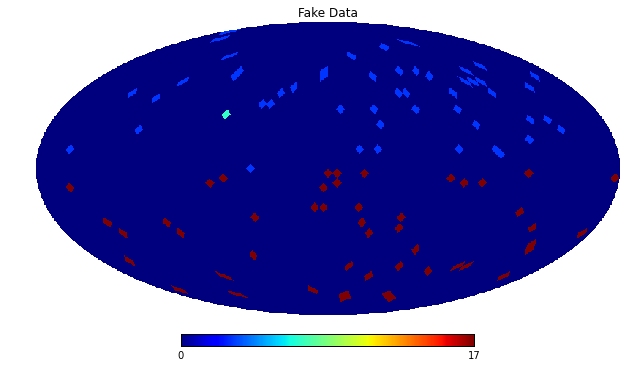

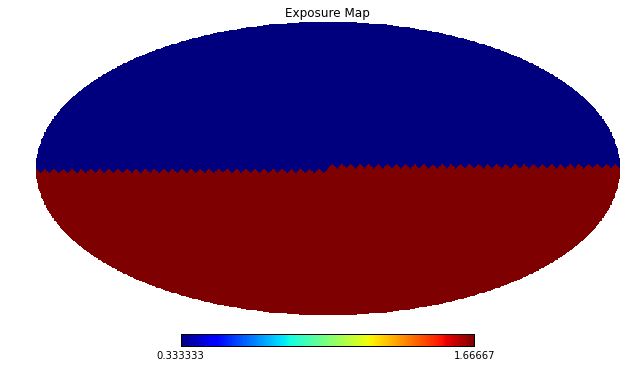

In [2]:
# Setup data and exposure
nside = 16
nps = 100
psc = 10
ner = 4
emaxval = 5.0

npix = hp.nside2npix(nside)
#theta, phi = hp.pix2ang(nside,range(npix))
#H1 = np.where(theta <= np.pi/2)[0]
#H2 = np.where(theta > np.pi/2)[0]
exposure = np.zeros(npix)
#exposure[H1] = 1.0
#exposure[H2] = emaxval
exposure[0:npix/2] = 1.0
exposure[npix/2:npix] = emaxval
exposure /= np.mean(exposure)
data = np.zeros(npix)
for ips in range(nps):
    loc = np.random.randint(npix)
    data[loc] += psc
data *= exposure
data = np.round(data).astype(int)
totaldata = np.sum(data)
print data[np.where(data != 0)]

hp.mollview(data,title='Fake Data')
hp.mollview(exposure,title='Exposure Map')

n = nptfit.NPTF(tag='Example10')
n.load_data(data, exposure)
nptf_iso = np.ones(npix)/exposure*np.mean(exposure)
n.add_template(nptf_iso, 'iso')
n.add_non_poiss_model('iso',
                      ['$A^\mathrm{ps}_\mathrm{iso}$','$n_1$','$n_2$','$S_b$'],
                      [[-3,0],[2.05,30],[-30,1.95],[0.01,20]],
                      [True,False,False,False])
n.configure_for_scan(nexp=ner)
n.perform_scan(nlive=500)

# Load and analyze the output
n.load_scan()
an=dnds_analysis.Analysis(n)
#print ""
#print "-----"
#print "1/exp template"
an.make_triangle()
plt.show()
plt.close()

an.plot_intensity_fraction_non_poiss('iso', bins=800, color='tomato', label='Iso PS',smin=0.01, smax=10000)
plt.close()
print "Flux fraction [16,50,84] percentiles:",an.qs_comp


# Manual calculation of the FF
Aiso_non_poiss_post, n_non_poiss_post, Sb_non_poiss_post = an.return_non_poiss_parameter_posteriors('iso')
A = np.percentile(Aiso_non_poiss_post,50)
n1 = np.percentile(n_non_poiss_post[0],50)
n2 = np.percentile(n_non_poiss_post[1],50)
Sb = np.percentile(Sb_non_poiss_post[0],50)

print "Median (A, n1, n2, Sb): (",A,", ",n1,", ",n2,", ",Sb,")"

print "Median of each param FF:",A*np.sum(nptf_iso)*Sb**2*(1/(n1-2)+1/(2-n2))/totaldata*100
print "Median of FFs over params:",np.percentile(np.array(Aiso_non_poiss_post)*np.sum(nptf_iso)*np.array(Sb_non_poiss_post[0])**2*(1/(np.array(n_non_poiss_post[0])-2)+1/(2-np.array(n_non_poiss_post[1]))),50)/totaldata*100

In [ ]:
# Setup and perform the scan
n = nptfit.NPTF(tag='Example10')
n.load_data(data, exposure)
nptf_iso = np.ones(npix)/exposure*np.mean(exposure)
n.add_template(nptf_iso, 'iso')
n.add_non_poiss_model('iso',
                      ['$A^\mathrm{ps}_\mathrm{iso}$','$n_1$','$n_2$','$S_b$'],
                      [[-3,0],[2.05,30],[-30,1.95],[0.01,20]],
                      [True,False,False,False])
n.configure_for_scan(nexp=ner)
n.perform_scan(nlive=500)

# Load and analyze the output
n.load_scan()
an=dnds_analysis.Analysis(n)
print ""
print "-----"
print "1/exp template"
#an.make_triangle()
#plt.show()
#plt.close()

an.plot_intensity_fraction_non_poiss('iso', bins=800, color='tomato', label='Iso PS',smin=0.01, smax=10000)
plt.close()
print "Flux fraction [16,50,84] percentiles:",an.qs_comp

# Manual calculation of the FF
Aiso_non_poiss_post, n_non_poiss_post, Sb_non_poiss_post = an.return_non_poiss_parameter_posteriors('iso')
A = np.percentile(Aiso_non_poiss_post,50)
n1 = np.percentile(n_non_poiss_post[0],50)
n2 = np.percentile(n_non_poiss_post[1],50)
Sb = np.percentile(Sb_non_poiss_post[0],50)

print "Median (A, n1, n2, Sb): (",A,", ",n1,", ",n2,", ",Sb,")"

print "Median of each param FF:",A*np.sum(nptf_iso)*Sb**2*(1/(n1-2)+1/(2-n2))/totaldata*100
print "Median of FFs over params:",np.percentile(np.array(Aiso_non_poiss_post)*np.sum(nptf_iso)*np.array(Sb_non_poiss_post[0])**2*(1/(np.array(n_non_poiss_post[0])-2)+1/(2-np.array(n_non_poiss_post[1]))),50)/totaldata*100
print ""

be1, l_be_err = an.get_log_evidence()

# Redo with potentially wrong template exposure
# Setup and perform the scan
n = nptfit.NPTF(tag='Example10')
n.load_data(data, exposure)
nptf_iso = exposure
n.add_template(nptf_iso, 'iso')
n.add_non_poiss_model('iso',
                      ['$A^\mathrm{ps}_\mathrm{iso}$','$n_1$','$n_2$','$S_b$'],
                      [[-6,0],[2.05,30],[-30,1.95],[0.01,20]],
                      [True,False,False,False])
n.configure_for_scan(nexp=ner)
n.perform_scan(nlive=500)

# Load and analyze the output
n.load_scan()
an=dnds_analysis.Analysis(n)
print ""
print "-----"
print "exp template"
#an.make_triangle()
#plt.show()
#plt.close()

an.plot_intensity_fraction_non_poiss('iso', bins=800, color='tomato', label='Iso PS',smin=0.01, smax=10000)
plt.close()
print "Flux fraction [16,50,84] percentiles:",an.qs_comp

# Manual calculation of the FF
Aiso_non_poiss_post, n_non_poiss_post, Sb_non_poiss_post = an.return_non_poiss_parameter_posteriors('iso')
A = np.percentile(Aiso_non_poiss_post,50)
n1 = np.percentile(n_non_poiss_post[0],50)
n2 = np.percentile(n_non_poiss_post[1],50)
Sb = np.percentile(Sb_non_poiss_post[0],50)

print "Median (A, n1, n2, Sb): (",A,", ",n1,", ",n2,", ",Sb,")"

print "Median of each param FF:",A*np.sum(nptf_iso)*Sb**2*(1/(n1-2)+1/(2-n2))/totaldata*100
print "Median of FFs over params:",np.percentile(np.array(Aiso_non_poiss_post)*np.sum(nptf_iso)*np.array(Sb_non_poiss_post[0])**2*(1/(np.array(n_non_poiss_post[0])-2)+1/(2-np.array(n_non_poiss_post[1]))),50)/totaldata*100
print ""

be2, l_be_err = an.get_log_evidence()

# Try the same with a flat map, see if it falls in the middle...

# Setup and perform the scan
n = nptfit.NPTF(tag='Example10')
n.load_data(data, exposure)
nptf_iso = np.ones(npix)
n.add_template(nptf_iso, 'iso')
n.add_non_poiss_model('iso',
                      ['$A^\mathrm{ps}_\mathrm{iso}$','$n_1$','$n_2$','$S_b$'],
                      [[-6,0],[2.05,30],[-30,1.95],[0.01,20]],
                      [True,False,False,False])
n.configure_for_scan(nexp=ner)
n.perform_scan(nlive=500)

# Load and analyze the output
n.load_scan()
an=dnds_analysis.Analysis(n)
print ""
print "-----"
print "flat template"
#an.make_triangle()
#plt.show()
#plt.close()

an.plot_intensity_fraction_non_poiss('iso', bins=800, color='tomato', label='Iso PS',smin=0.01, smax=10000)
plt.close()
print "Flux fraction [16,50,84] percentiles:",an.qs_comp

# Manual calculation of the FF
Aiso_non_poiss_post, n_non_poiss_post, Sb_non_poiss_post = an.return_non_poiss_parameter_posteriors('iso')
A = np.percentile(Aiso_non_poiss_post,50)
n1 = np.percentile(n_non_poiss_post[0],50)
n2 = np.percentile(n_non_poiss_post[1],50)
Sb = np.percentile(Sb_non_poiss_post[0],50)

print "Median (A, n1, n2, Sb): (",A,", ",n1,", ",n2,", ",Sb,")"

print "Median of each param FF:",A*np.sum(nptf_iso)*Sb**2*(1/(n1-2)+1/(2-n2))/totaldata*100
print "Median of FFs over params:",np.percentile(np.array(Aiso_non_poiss_post)*np.sum(nptf_iso)*np.array(Sb_non_poiss_post[0])**2*(1/(np.array(n_non_poiss_post[0])-2)+1/(2-np.array(n_non_poiss_post[1]))),50)/totaldata*100
print ""

be3, l_be_err = an.get_log_evidence()

print "Log Bayesian Evidence for 1/exp over exp:",be1-be2
print "Log Bayesian Evidence for 1/exp over flat:",be1-be3
print "Log Bayesian Evidence for exp over flat:",be2-be3